# 8. Gyakorlat: Generatív modellezés - Gauss-i keverékek

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_olivetti_faces
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import StratifiedShuffleSplit

warnings.filterwarnings('ignore')

---
## Olivetti-arcok osztályozása
### Adathalmaz betöltése

In [3]:
olivetti = fetch_olivetti_faces()
print(olivetti.DESCR)
print(olivetti.target)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/daniel/scikit_learn_data
.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for s

### Ábrázoljunk egy párat az Olivetti arcokból. Pl. minden huszadikat

In [10]:
# Egy függvény az arcok ábrázolásához
def plot_faces(faces, labels, n_cols=5, title="", fs=(15,15)):
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=fs)
    plt.title(title)
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face.reshape(64, 64), cmap="gray") # Kép kirakása az ax-ra
        plt.axis("off")
        plt.title(label)
    plt.axis('off')
    plt.show()

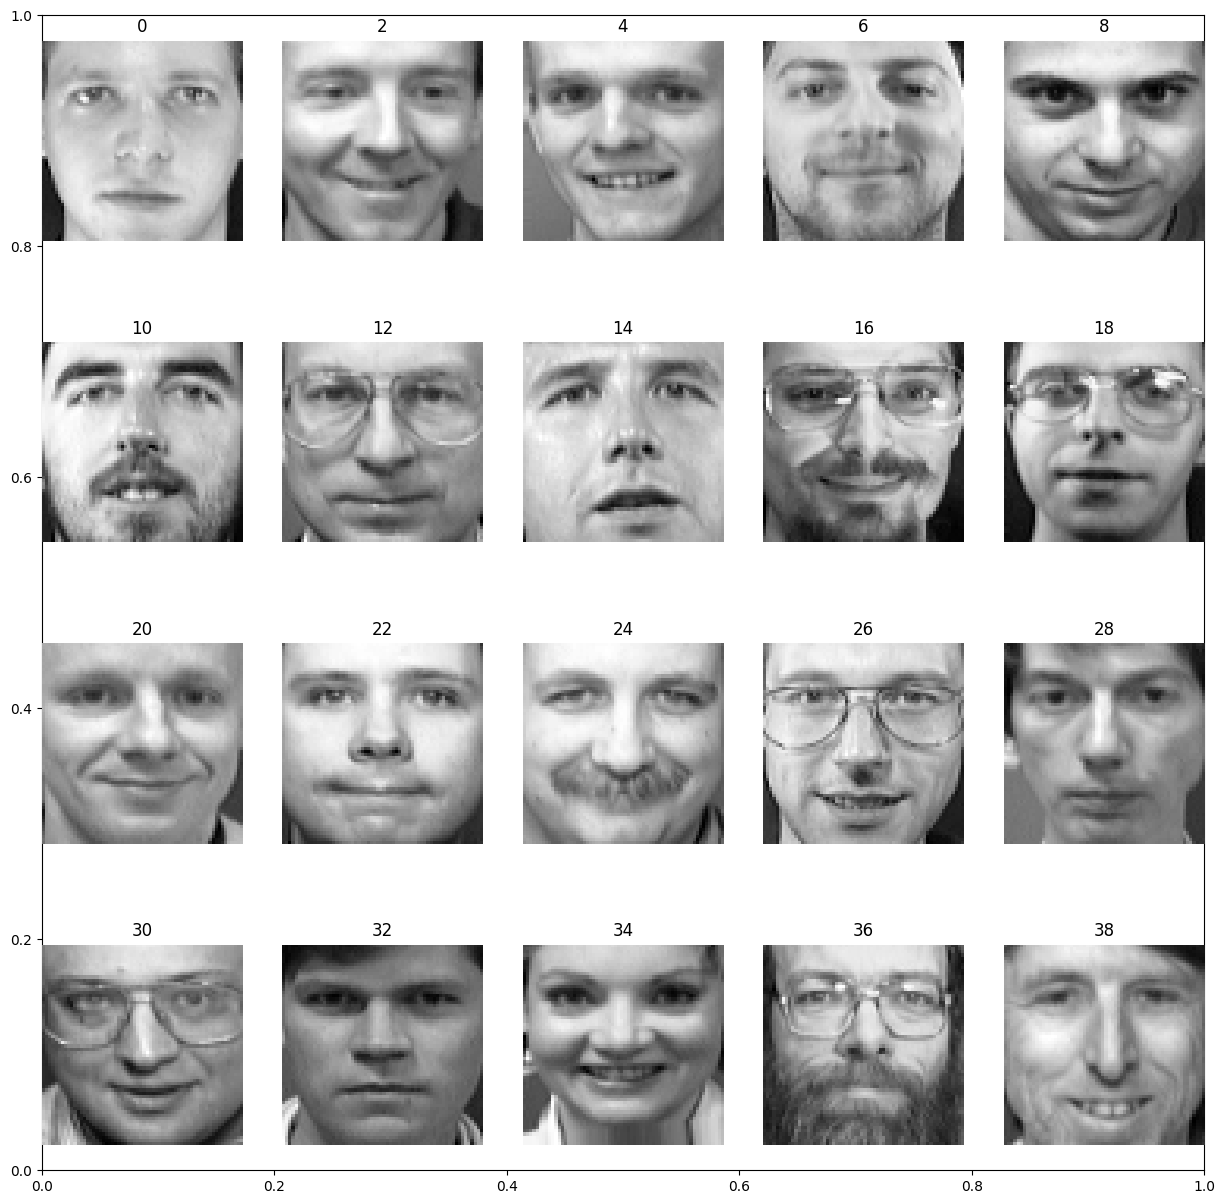

In [11]:
inds = [x for x in range(0, 400, 20)] # Indexek leválasztása. Ez személyre szabható. 
plot_faces(olivetti.data[inds], olivetti.target[inds])

### Tanító-teszt szétválasztás

In [12]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

### Képek egyszerűsítése főkomponenselemzés segítségével

In [13]:
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

### Gauss-i keverék modell tanítása

In [14]:
gm = GMM(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

### Generáljunk új arcokat véletlen mintavétellel!

In [15]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

### Ábárzoljuk ezeket

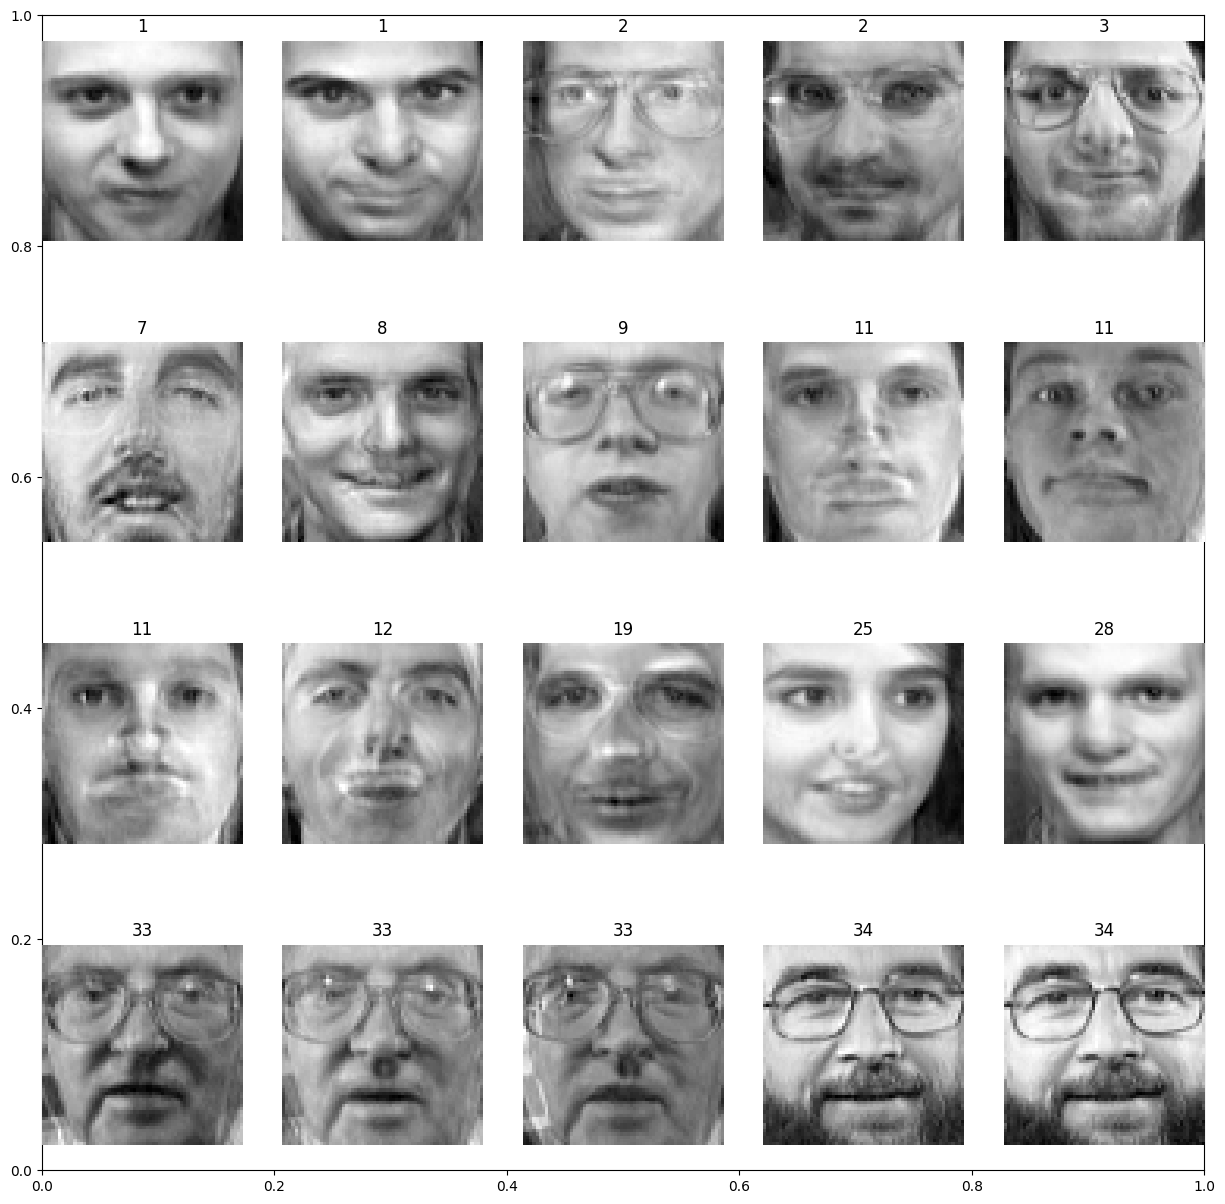

In [16]:
plot_faces(gen_faces, y_gen_faces)

### Módosítsunk néhány arcot, majd nézzük meg, a modell felismeri-e anomáliaként

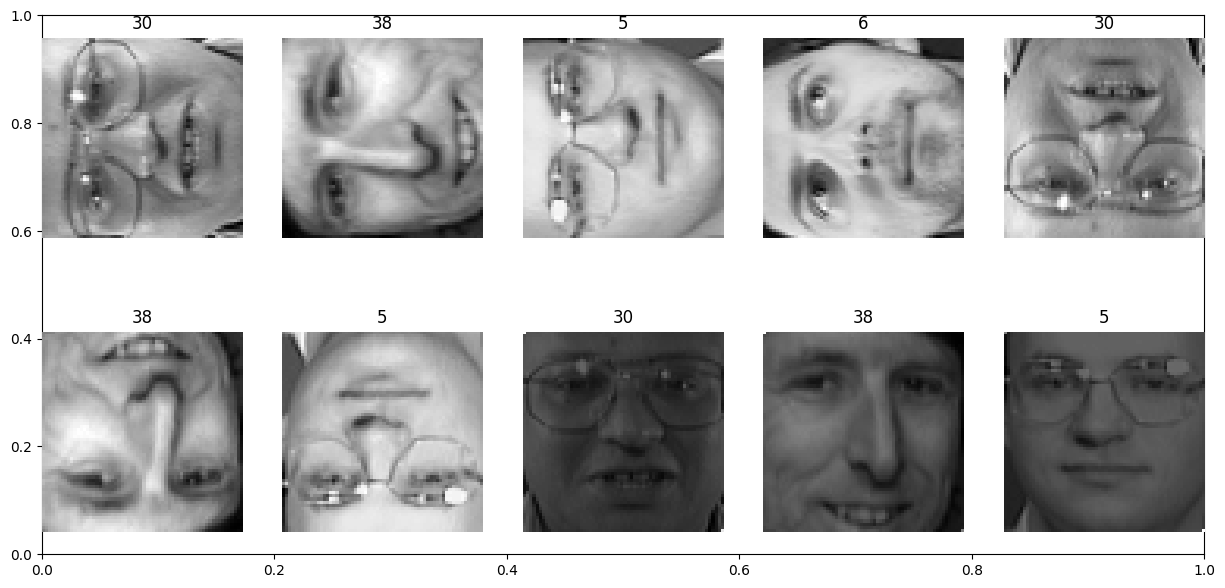

In [18]:
n_rotated = 4 # Forgasson el 4 képet
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3 # Fordítson fejjel lefele 3 képet
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3 # Sötétítsen el 3 képet
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 64*64)
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened] # Összefűzés 1 adathalmazba
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad, n_cols=5, fs=(15,7))

### Anomália detekció

In [20]:
X_bad_faces_pca = pca.transform(X_bad_faces)

print('Anomáliák valószínűség-sűrűségei:')
print(gm.score_samples(X_bad_faces_pca))
print()
print('Eredeti arcok valószínűség-sűrűségei:')
print(gm.score_samples(X_train_pca[:10]))

Anomáliák valószínűség-sűrűségei:
[-1.85962807e+07 -1.73014205e+07 -4.15206550e+07 -4.81260076e+07
 -3.20478920e+07 -1.35426825e+07 -2.92373991e+07 -9.25150403e+07
 -1.03272461e+08 -5.41697161e+07]

Eredeti arcok valószínűség-sűrűségei:
[1163.02020895 1112.1730818  1156.32132767 1170.67602764 1073.69245826
 1139.89252777 1113.76629815 1073.69244587 1048.17522516 1048.17520399]


---
## Új adatok generálása az MNIST adathalmaz alapján

In [21]:
digits = load_digits()
digits.data.shape

(1797, 64)

### Ábrázoljuk az adatokat

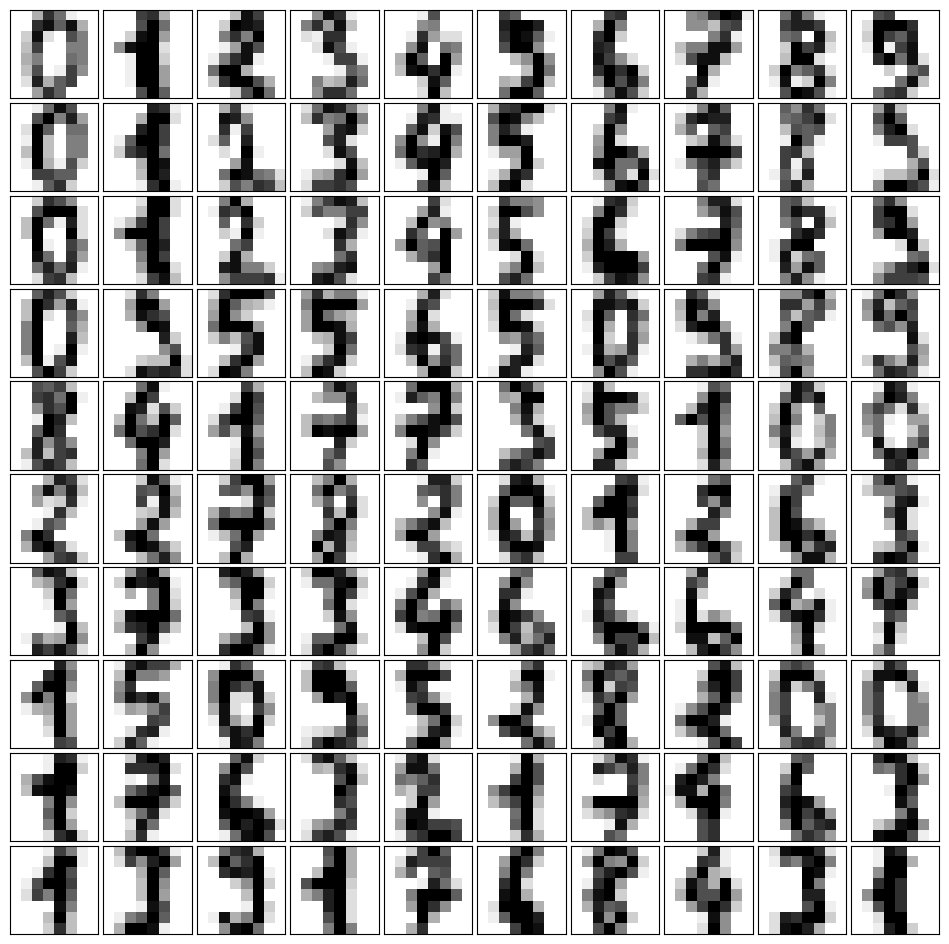

In [22]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(12, 12), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

plot_digits(digits.data)

### Főkomponenselemzés az adatokon

In [23]:
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
print(data.shape)

(1797, 41)


### Komponensek számának megtalálása

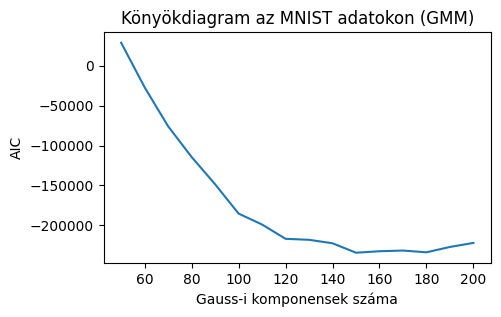

In [27]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0) for n in n_components]
aics = [model.fit(data).aic(data) for model in models]

plt.figure(figsize=(5, 3))
plt.plot(n_components, aics)
plt.title('Könyökdiagram az MNIST adatokon (GMM)')
plt.xlabel('Gauss-i komponensek száma')
plt.ylabel('AIC')
plt.show()

### Gauss-i keverék modell illesztése az adathalmazra

In [28]:
gmm = GMM(140, covariance_type='full', random_state=0)
gmm.fit(data)
print('Konvergált: ', gmm.converged_)

Konvergált:  True


### Új adatpontok generálása véletlen mintavétellel

In [29]:
data_new = gmm.sample(100)[0]
print(data_new.shape)

(100, 41)


### Adatpontok visszaalakítása PCA-inverz transzformációval

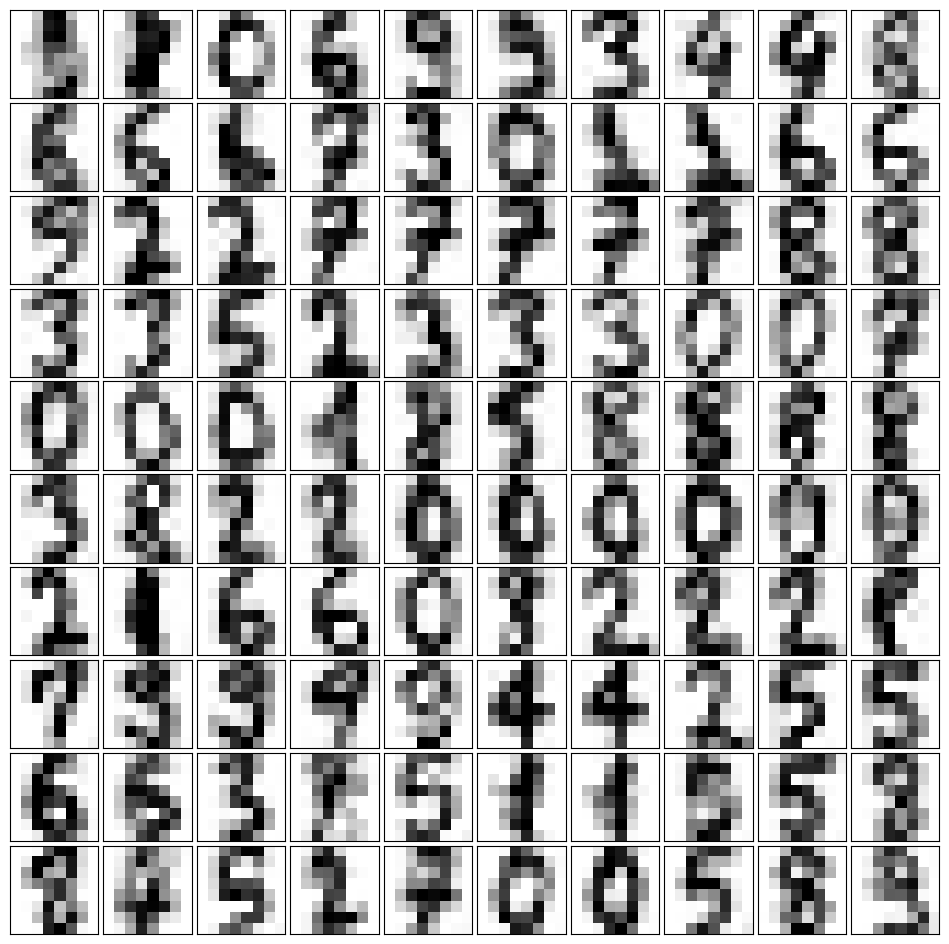

In [30]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)